In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt
import os
import sklearn
import mne
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Import data
directory = 'Data'
participants = ['Aharon', 'Conor', 'John']
directory_2 = 'One\Thalmic Labs MyoMyo'
frames = []
for participant in participants:
    for count, filename in enumerate(os.listdir(os.path.join(directory, participant, directory_2))):
        df = pd.read_csv(os.path.join(directory, participant, directory_2, filename))
        df.drop(['Timestamp','Device ID','Warm?','Sync','Arm','Timestamp.1','Pose','Locked','RSSI','Device_Time'], axis=1, inplace=True)
        
        df.drop(['Orientation_W'], axis=1, inplace=True)
        
        df['Participant'] = [participant] * df.shape[0]
        filename = filename.split('_')
        if len(filename) == 3:
            df['Class'] = [filename[0]] * df.shape[0]
            df['Trial'] = [filename[1]] * df.shape[0]
        else:
            df['Class'] = [filename[0] + ' ' + filename[1]] * df.shape[0]
            df['Trial'] = [filename[2]] * df.shape[0]
        frames.append(df)
# data = pd.concat(frames)

In [3]:
# Preprocess EMG
def filteremg(emg, notch=60, quality=60, sfreq=200, high_band=20, low_band=95):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    # Zero mean emg signal
    emg = emg - emg.mean()
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass', analog=True)
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    notch = notch/(sfreq)
    b2, a2 = sp.signal.iirnotch(notch, quality, fs=sfreq)
    emg_envelope = sp.signal.lfilter(b2, a2, emg_rectified)
    
    return emg_envelope

emg_keys = ['EMG_' + str(i) for i in range(1, 9)]
imu_keys = ['Orientation_X','Orientation_Y','Orientation_Z','Gyro_X','Gyro_Y','Gyro_Z','Acc_X', 'Acc_Y', 'Acc_Z']

for frame in frames:
    frame[emg_keys] = frame[emg_keys].apply(filteremg, raw=True)

    # for channel in range(1,9):
    #     f, Pxx_den = sp.signal.periodogram(frame['EMG_' + str(channel)], 200)
    #     plt.figure()
    #     plt.semilogy(f, Pxx_den)
    #     plt.title('EMG_' + str(channel) + ' PSD')
    #     plt.ylim([1e-7, 1e2])
    #     plt.xlabel('frequency [Hz]')
    #     plt.ylabel('PSD [V**2/Hz]')
    #     plt.show()
    #         plt.savefig(directory + 'EMG_' + str(channel) + ' PSD.png')
    #     display('EMG_' + str(channel) + ' max power:', max(Pxx_den))
    for col in emg_keys:
        frame[col] = frame[col].rolling(20).mean() # how many samples should I make my window?
#     for channel in range(1,9):
#         plt.figure()
#         ax = frame['EMG_' + str(channel)].plot()
#         plt.title('EMG_' + str(channel) + ' Filtered')
#         plt.ylabel('mVolts')
#         plt.xlabel('Time')
    #         plt.savefig(directory + 'EMG_' + str(channel) + ' Filtered.png')

In [4]:
# Preprocess IMU
for frame in frames:
    for col in imu_keys:
        frame[col] = frame[col].rolling(5).mean()  # how many samples should I make my window?
    # for channel in ['X', 'Y', 'Z']:
    #     plt.figure()
    #     frame['Acc_' + channel].plot()
    #     plt.title('Acc_' + str(channel))
    #     plt.ylabel('g')
    #     plt.xlabel('Time')

In [5]:
# Feature Extraction
# Root Mean Square
def get_RMS(signal):
    ans = np.sqrt(np.average(np.square(signal)))
    return ans

# # Integral
# def get_IL(signal):
#     ans = np.sum(np.absolute(signal))
#     return ans

# Waveform Length
def get_WL(signal):
    ans = np.log(sum([np.absolute(signal[i+1] - signal[i]) for i in range(len(signal)-1)]))
    return ans

# Mean Absolute Value
def get_MAV(signal):
    ans = np.average(np.absolute(signal))
    return ans

# Slope Sign Change
# def get_SSC(signal):
#     ans = 0
#     for i in range(len(signal)-1):
#         if 
#     return ans

# Variance
def get_VAR(signal):
    ans = np.var(signal)
    return ans

# Max Power
def get_MAXP(signal):
    f, Pxx_den = sp.signal.periodogram(signal, 200)
    ans = max(Pxx_den)
    return ans

# Range of Values
def get_dRange(signal):
    ans = max(signal) - min(signal)
    return ans

# Max Value
def get_MAX(signal):
    ans = max(signal)
    return ans

def extract_features(dataframe, emg_channels, or_channels, gyro_channels, acc_channels):
    feat_dict = {}
    for chan in emg_channels:
        feat_dict[chan + '_RMS'] = get_RMS(dataframe[chan].dropna().reset_index(drop=True))
#         feat_dict[chan + '_IL'] = get_IL(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_WL'] = get_WL(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_MAV'] = get_MAV(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_VAR'] = get_VAR(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_MAXP'] = get_MAXP(dataframe[chan].dropna().reset_index(drop=True))
        feat_dict[chan + '_MAX'] = get_MAX(dataframe[chan].dropna().reset_index(drop=True))
    for chan in or_channels:
        feat_dict[chan + '_dOrient'] = get_dRange(dataframe[chan].dropna().reset_index(drop=True))
    for chan in gyro_channels:
        feat_dict[chan + '_dGyro'] = get_dRange(dataframe[chan].dropna().reset_index(drop=True))
    for chan in or_channels + gyro_channels + acc_channels:
        feat_dict[chan + '_VAR'] = get_VAR(dataframe[chan].dropna().reset_index(drop=True))
    for chan in acc_channels:
        feat_dict[chan + '_MAX'] = get_MAX(dataframe[chan].dropna().reset_index(drop=True))
    return feat_dict

or_keys = imu_keys[:4]
gyro_keys = imu_keys[4:7]
acc_keys = imu_keys[7:]

feature_df = pd.DataFrame()
for frame in frames:
    feats = extract_features(frame, emg_keys, or_keys, gyro_keys, acc_keys)
    feats['Participant'] = frame['Participant']
    feats['Class'] = frame['Class']
    feats['Trial'] = frame['Trial']
    feature_df = pd.concat([feature_df, pd.DataFrame(feats, index=[0])], ignore_index=True)

In [6]:
# Setup Data for ML

# train_cols = list(feature_df)[:-3]
emg_cols = list(feature_df)[:48]
imu_cols = list(feature_df)[48:66]

classes = np.unique(feature_df['Class'])
class_to_int = {c:i for i, c in enumerate(classes)}
y_cols = ['y_' + str(i) for i in range(len(classes))]
one_hot_matrix = np.zeros((len(feature_df), len(classes)))
for i, c in enumerate(feature_df['Class']):
    index = class_to_int[c]
    one_hot_matrix[i, index] = 1
y_df = pd.DataFrame(one_hot_matrix, columns=y_cols)
feature_df = pd.concat([feature_df,y_df], axis=1)

feature_train, feature_test = train_test_split(feature_df, train_size=0.8, test_size=0.2, shuffle=True)

x_emg = feature_train.loc[:,emg_cols]
x_imu = feature_train.loc[:,imu_cols]
min_max_scalar = MinMaxScaler()
x_emg_train = min_max_scalar.fit_transform(x_emg)
x_emg_test = min_max_scalar.transform(feature_test.loc[:,emg_cols])
x_imu_train = min_max_scalar.fit_transform(x_imu)
x_imu_test = min_max_scalar.transform(feature_test.loc[:,imu_cols])
y_train = feature_train.loc[:,y_cols].values
y_test = feature_test.loc[:,y_cols].values

Model: "myo_drone_model_fusion"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EMG_Input (InputLayer)         [(None, 48)]         0           []                               
                                                                                                  
 IMU_Input (InputLayer)         [(None, 18)]         0           []                               
                                                                                                  
 EMG_Dense_1 (Dense)            (None, 64)           3136        ['EMG_Input[0][0]']              
                                                                                                  
 IMU_Dense_1 (Dense)            (None, 64)           1216        ['IMU_Input[0][0]']              
                                                                             

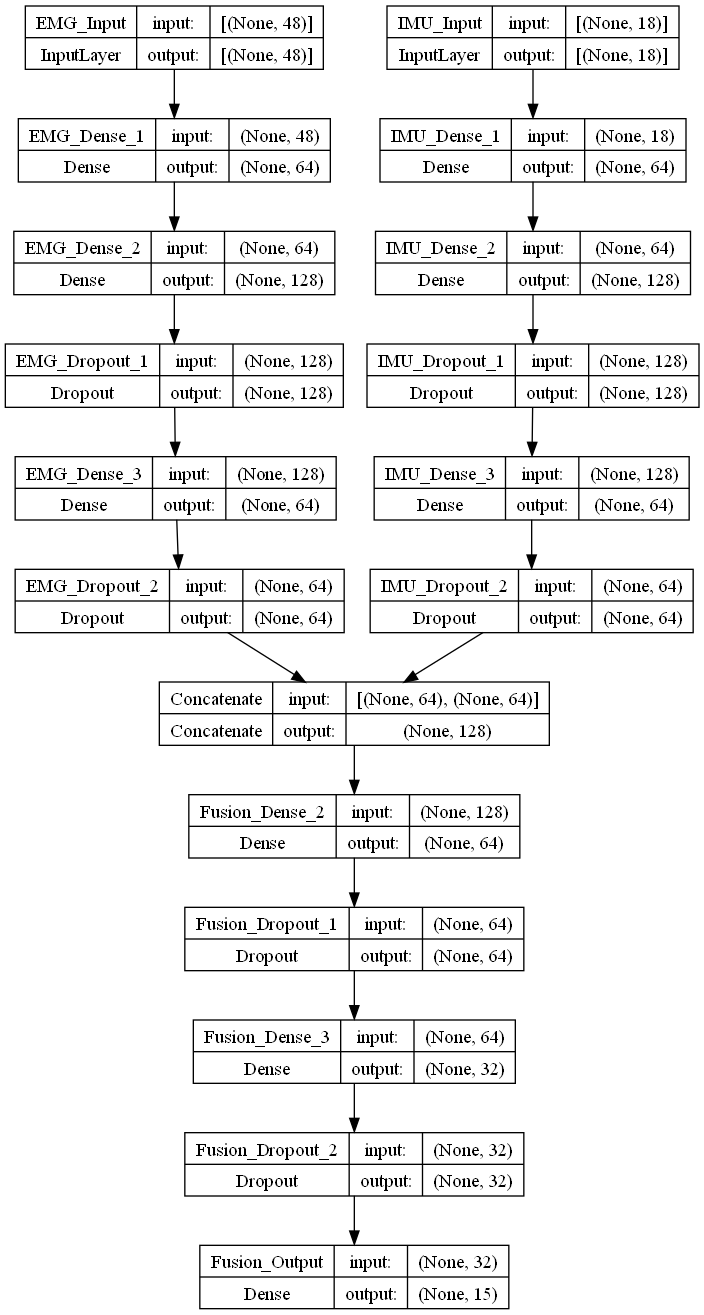

In [7]:
# Machine Learning, Fusion
# EMG
emg_inputs = keras.Input(shape=(48,), name='EMG_Input')
emg_dense_1 = layers.Dense(64, activation='relu', name='EMG_Dense_1')
next_emg = emg_dense_1(emg_inputs)
next_emg = layers.Dense(128, activation='relu', name='EMG_Dense_2')(next_emg)
next_emg = layers.Dropout(0.1, name='EMG_Dropout_1')(next_emg)
next_emg = layers.Dense(64, activation='relu', name='EMG_Dense_3')(next_emg)
emg_outputs = layers.Dropout(0.1, name='EMG_Dropout_2')(next_emg)
# emg_outputs = layers.Dense(15, activation='softmax', name='EMG_Output')(next_emg)

# IMU
imu_inputs = keras.Input(shape=(18,), name='IMU_Input')
imu_dense_1 = layers.Dense(64, activation='relu', name='IMU_Dense_1')
next_imu = imu_dense_1(imu_inputs)
next_imu = layers.Dense(128, activation='relu', name='IMU_Dense_2')(next_imu)
next_imu = layers.Dropout(0.1, name='IMU_Dropout_1')(next_imu)
next_imu = layers.Dense(64, activation='relu', name='IMU_Dense_3')(next_imu)
imu_outputs = layers.Dropout(0.1, name='IMU_Dropout_2')(next_imu)
# imu_outputs = layers.Dense(15, activation='softmax', name='IMU_Output')(next_imu)

# Fusion
next_fusion = layers.concatenate([emg_outputs, imu_outputs], name='Concatenate')
fusion_dense_1 = layers.Dense(128, activation='relu', name='Fusion_Dense_1')(next_fusion)
next_fusion = layers.Dense(64, activation='relu', name='Fusion_Dense_2')(next_fusion)
next_fusion = layers.Dropout(0.1, name='Fusion_Dropout_1')(next_fusion)
next_fusion = layers.Dense(32, activation='relu', name='Fusion_Dense_3')(next_fusion)
next_fusion = layers.Dropout(0.1, name='Fusion_Dropout_2')(next_fusion)
fusion_outputs = layers.Dense(15, activation='softmax', name='Fusion_Output')(next_fusion)
fusion_model = keras.Model(inputs=[emg_inputs, imu_inputs], outputs=fusion_outputs, name='myo_drone_model_fusion')
fusion_model.summary()
keras.utils.plot_model(fusion_model, "myo_drone_model_fusion.png", show_shapes=True)

In [8]:
fusion_model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy','mse'])

fusion_model.fit(
    {'EMG_Input': x_emg_train, 'IMU_Input': x_imu_train},
    {'Fusion_Output': y_train},
    epochs=300
)

Epoch 1/300
8/8 [==============================] - 1s 3ms/step - loss: 2.6996 - accuracy: 0.0667 - mse: 0.0621
Epoch 2/300
8/8 [==============================] - 0s 2ms/step - loss: 2.6519 - accuracy: 0.1833 - mse: 0.0617
Epoch 3/300
8/8 [==============================] - 0s 2ms/step - loss: 2.5791 - accuracy: 0.2500 - mse: 0.0609
Epoch 4/300
8/8 [==============================] - 0s 2ms/step - loss: 2.4513 - accuracy: 0.2625 - mse: 0.0593
Epoch 5/300
8/8 [==============================] - 0s 2ms/step - loss: 2.3103 - accuracy: 0.2833 - mse: 0.0571
Epoch 6/300
8/8 [==============================] - 0s 2ms/step - loss: 2.1203 - accuracy: 0.3417 - mse: 0.0537
Epoch 7/300
8/8 [==============================] - 0s 2ms/step - loss: 1.9460 - accuracy: 0.3292 - mse: 0.0509
Epoch 8/300
8/8 [==============================] - 0s 2ms/step - loss: 1.8066 - accuracy: 0.4042 - mse: 0.0478
Epoch 9/300
8/8 [==============================] - 0s 2ms/step - loss: 1.6228 - accuracy: 0.4583 - mse: 0.0445
E

8/8 [==============================] - 0s 2ms/step - loss: 0.0969 - accuracy: 0.9708 - mse: 0.0031
Epoch 75/300
8/8 [==============================] - 0s 2ms/step - loss: 0.1119 - accuracy: 0.9708 - mse: 0.0037
Epoch 76/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9917 - mse: 0.0021
Epoch 77/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0897 - accuracy: 0.9667 - mse: 0.0031
Epoch 78/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9750 - mse: 0.0025
Epoch 79/300
8/8 [==============================] - 0s 3ms/step - loss: 0.0951 - accuracy: 0.9750 - mse: 0.0031
Epoch 80/300
8/8 [==============================] - 0s 3ms/step - loss: 0.1495 - accuracy: 0.9417 - mse: 0.0051
Epoch 81/300
8/8 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9458 - mse: 0.0055
Epoch 82/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9833 - mse: 0.0025
Epoch

8/8 [==============================] - 0s 1ms/step - loss: 0.0252 - accuracy: 0.9917 - mse: 6.8740e-04
Epoch 147/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9833 - mse: 0.0014
Epoch 148/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0278 - accuracy: 0.9917 - mse: 9.0050e-04
Epoch 149/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9958 - mse: 6.0020e-04
Epoch 150/300
8/8 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 0.9958 - mse: 7.8829e-04
Epoch 151/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9958 - mse: 4.4697e-04
Epoch 152/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0409 - accuracy: 0.9875 - mse: 0.0014
Epoch 153/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9917 - mse: 9.8935e-04
Epoch 154/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0202 - accu

8/8 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9958 - mse: 2.9115e-04
Epoch 217/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0403 - accuracy: 0.9875 - mse: 0.0012
Epoch 218/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 1.0000 - mse: 7.0349e-05
Epoch 219/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9958 - mse: 4.2927e-04
Epoch 220/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9917 - mse: 7.6526e-04
Epoch 221/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9792 - mse: 0.0013
Epoch 222/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 1.0000 - mse: 2.9080e-04
Epoch 223/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9833 - mse: 0.0011
Epoch 224/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy

8/8 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 1.0000 - mse: 1.0511e-04
Epoch 287/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9917 - mse: 7.3149e-04
Epoch 288/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 1.0000 - mse: 2.5839e-04
Epoch 289/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 6.4604e-05
Epoch 290/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9917 - mse: 6.1110e-04
Epoch 291/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9958 - mse: 6.1945e-04
Epoch 292/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9875 - mse: 9.0728e-04
Epoch 293/300
8/8 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9958 - mse: 7.3024e-04
Epoch 294/300
8/8 [==============================] - 0s 2ms/step - loss: 0.017

In [9]:
fusion_model.evaluate(
    {'EMG_Input': x_emg_test, 'IMU_Input': x_imu_test},
    {'Fusion_Output': y_test}
)

2/2 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9667 - mse: 0.0039


[0.16854247450828552, 0.9666666388511658, 0.003936040215194225]

2/2 [==============================] - 0s 1ms/step


,precision,recall,f1-score,support
1,1.000000,1.000000,1.000000,4.000000
2,0.666667,1.000000,0.800000,2.000000
3,1.000000,1.000000,1.000000,3.000000
4,1.000000,1.000000,1.000000,2.000000
5,1.000000,1.000000,1.000000,6.000000
6,1.000000,1.000000,1.000000,8.000000
7,0.857143,1.000000,0.923077,6.000000
8,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,5.000000
10,1.000000,1.000000,1.000000,2.000000


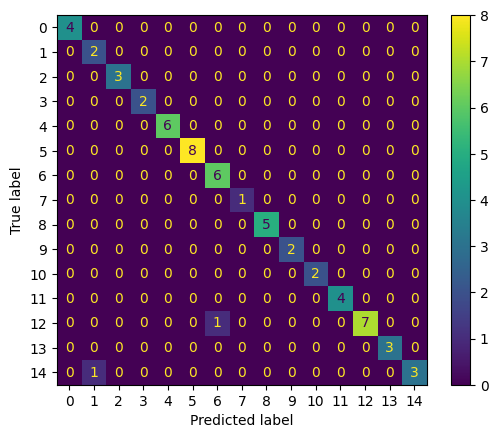

In [10]:
predicted = fusion_model.predict({'EMG_Input': x_emg_test, 'IMU_Input': x_imu_test})
predicted = np.argmax(predicted, axis=1)+1
true = np.argmax(y_test, axis=1)+1
display(pd.DataFrame(classification_report(true, predicted, output_dict=True)).transpose())

cm = confusion_matrix(true, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [11]:
fusion_model.save("Aharon_Fusion_Model")

INFO:tensorflow:Assets written to: Aharon_Fusion_Model\assets


INFO:tensorflow:Assets written to: Aharon_Fusion_Model\assets


In [12]:
display(list(feature_df)[48:66])

['Orientation_X_dOrient',
 'Orientation_Y_dOrient',
 'Orientation_Z_dOrient',
 'Gyro_X_dOrient',
 'Gyro_Y_dGyro',
 'Gyro_Z_dGyro',
 'Acc_X_dGyro',
 'Orientation_X_VAR',
 'Orientation_Y_VAR',
 'Orientation_Z_VAR',
 'Gyro_X_VAR',
 'Gyro_Y_VAR',
 'Gyro_Z_VAR',
 'Acc_X_VAR',
 'Acc_Y_VAR',
 'Acc_Z_VAR',
 'Acc_Y_MAX',
 'Acc_Z_MAX']